In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
os.environ["KERAS_BACKEND"] = "torch"
import keras
from datamodules import data_processors
import sys
print(sys.version)

3.13.1 (main, Dec  9 2024, 00:00:00) [GCC 14.2.1 20240912 (Red Hat 14.2.1-3)]


In [2]:
N_archivos = 7
path_rand = map(lambda x: "../input_data/cubic_" + str(x + 1) + ".csv", range(N_archivos))
datos_rand = [pd.read_csv(x) for x in path_rand]
path_to_current_model = "none" #"models/isotropico_act_custom_6.keras" # colocar "none" si quiere entrenar un modelo

In [3]:
datos_rand[0].head()

,phi_a,x_K,eta,beta,phi_K,eig_0,eig_1,eig_2,eig_3,eig_4,...,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,Parallelepiped,Cylinder,Ellipsoid
0,0.843666,0.647473,1.577259,1.574131,0.866533,0.552390,2.341186,2.982731,4.346947,4.543615,...,10.255629,10.934964,12.169362,12.639375,13.023291,17.260278,18.912029,1,0,0
1,0.618911,0.218057,1.216162,1.820191,1.350973,0.451902,1.069440,2.198825,3.912317,3.934114,...,11.230938,11.241764,11.468446,14.561622,14.919805,15.338283,15.666733,1,0,0
2,0.076877,0.245986,1.434582,2.036289,1.322259,0.104398,3.832743,4.758215,5.732612,5.807000,...,15.088024,15.429422,16.241738,16.394792,20.165109,25.500514,26.305482,1,0,0
3,1.459619,0.517388,1.481719,1.376496,1.027000,0.202136,2.142934,2.641222,2.779140,3.088002,...,10.969815,12.756643,13.922951,14.045571,15.047647,18.770442,19.392401,1,0,0
4,0.032508,0.949501,1.839938,0.803203,0.319154,0.002714,10.061990,13.963490,14.997477,17.405756,...,56.063736,70.470168,72.668095,76.780522,93.416045,97.561829,106.012724,1,0,0


In [4]:
N_eig = 19
features = list(map(lambda x: "x_" + str(x+1), range(N_eig))) + list(map(lambda x: "g" + str(x), range(6))) + ["eta", "beta"]
target = ["phi_a", "phi_K"]

In [5]:
datos_post = []
for datos in datos_rand:
    datos_post.append(data_processors.preprocess_data(datos, N_eig, target, angle_targets = False))
#fin for 
datos_rand = datos_post

In [6]:
for datos in datos_rand:
    datos["c_a"] = np.sin(datos["phi_K"])*np.cos(datos["phi_a"])
    datos["c_K"] = np.cos(datos["phi_K"])
    data_processors.create_additional_geometric_features(datos)
#fin for
target = ["c_K", "c_a"]

In [7]:
datos_rand[0].head()

,phi_a,phi_K,eig_0,eta,beta,eig_1,eig_2,eig_3,eig_4,eig_5,...,x_18,x_19,c_a,c_K,g0,g1,g2,g3,g4,g5
0,0.843666,0.866533,0.552390,1.577259,1.574131,0.427134,0.784913,0.686167,0.956716,0.970898,...,0.224037,0.087339,0.506582,0.647473,0.292634,1.697578,0.252853,0.655163,0.272017,0.704818
1,0.618911,1.350973,0.451902,1.216162,1.820191,0.935069,0.486369,0.562026,0.994460,0.833391,...,0.026711,0.020965,0.794910,0.218057,0.401588,1.677402,0.156988,0.513159,0.251086,0.820746
2,0.076877,1.322259,0.104398,1.434582,2.036289,0.260910,0.805500,0.830026,0.987190,0.736554,...,0.202825,0.030601,0.966411,0.245986,0.420609,1.350176,0.244018,0.573992,0.320369,0.753589
3,1.459619,1.027000,0.202136,1.481719,1.376496,0.466650,0.811342,0.950374,0.899980,0.743699,...,0.191972,0.032072,0.094944,0.517388,0.264447,2.058935,0.196059,0.635353,0.227700,0.737889
4,0.032508,0.319154,0.002714,1.839938,0.803203,0.099384,0.720593,0.931056,0.861639,0.698142,...,0.039106,0.079716,0.313598,0.949501,0.123316,2.976483,0.204191,0.779597,0.158682,0.605845


In [8]:
X_rand = [datos_rand[x][features] for x in range(N_archivos)]
y_rand = [datos_rand[x][target] for x in range(N_archivos)]

In [9]:
X_train = pd.concat((X_rand[i] for i in range(5)), axis = 0)
y_train = pd.concat((y_rand[i] for i in range(5)), axis = 0)
datos_train = pd.concat((X_train, y_train), axis = 1)

In [10]:
print(len(features))
X_train.head()

27


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_18,x_19,g0,g1,g2,g3,g4,g5,eta,beta
0,0.070917,0.033923,0.072135,0.010399,0.007201,0.014744,0.043735,0.074120,0.040427,0.044254,...,0.224037,0.087339,0.292634,1.697578,0.252853,0.655163,0.272017,0.704818,1.577259,1.574131
1,0.004432,0.072088,0.109371,0.001391,0.050202,0.004016,0.031852,0.143750,0.023422,0.036307,...,0.026711,0.020965,0.401588,1.677402,0.156988,0.513159,0.251086,0.820746,1.216162,1.820191
2,0.107686,0.035182,0.037042,0.002828,0.078957,0.007227,0.043786,0.025159,0.008580,0.024378,...,0.202825,0.030601,0.420609,1.350176,0.244018,0.573992,0.320369,0.753589,1.434582,2.036289
3,0.058937,0.025695,0.007112,0.015927,0.054878,0.011324,0.097216,0.004204,0.105779,0.023561,...,0.191972,0.032072,0.264447,2.058935,0.196059,0.635353,0.227700,0.737889,1.481719,1.376496
4,0.085480,0.036802,0.009753,0.022717,0.070989,0.010528,0.033579,0.038539,0.012061,0.060522,...,0.039106,0.079716,0.123316,2.976483,0.204191,0.779597,0.158682,0.605845,1.839938,0.803203


In [11]:
corr_mat = datos_train.select_dtypes(include=['number']).corr()
print(corr_mat)

           x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
x_1   1.000000  0.182083  0.054078  0.052991  0.169650  0.053046  0.062420   
x_2   0.182083  1.000000  0.030579  0.158458  0.165224  0.114739 -0.004028   
x_3   0.054078  0.030579  1.000000  0.160123 -0.042368  0.057401  0.375232   
x_4   0.052991  0.158458  0.160123  1.000000 -0.100712  0.178142  0.106587   
x_5   0.169650  0.165224 -0.042368 -0.100712  1.000000 -0.040620 -0.069817   
x_6   0.053046  0.114739  0.057401  0.178142 -0.040620  1.000000  0.022884   
x_7   0.062420 -0.004028  0.375232  0.106587 -0.069817  0.022884  1.000000   
x_8   0.215710  0.041753  0.080653  0.074202 -0.031095  0.015337 -0.001147   
x_9  -0.040744  0.070762 -0.040750 -0.012536  0.014343 -0.014157 -0.054891   
x_10 -0.173975 -0.031642 -0.066953 -0.033298 -0.067506  0.033925 -0.062560   
x_11 -0.083421 -0.034996 -0.046112 -0.046564 -0.121799 -0.017052 -0.052692   
x_12 -0.069793  0.026203 -0.029387 -0.036373 -0.049777 -0.068263

Text(0.5, 1.0, 'Correlation Matrix')

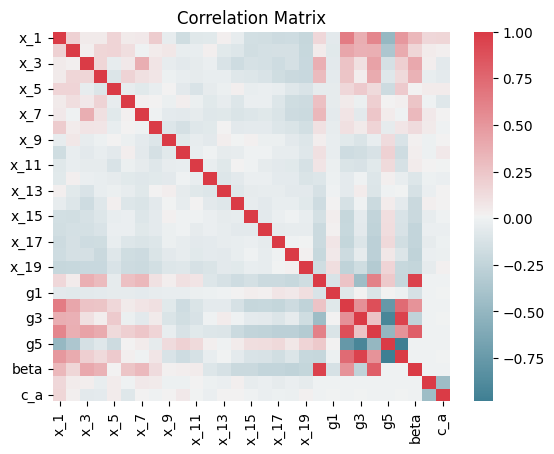

In [12]:
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

In [13]:
torch.cuda.get_device_properties(torch.device("cuda"))

_CudaDeviceProperties(name='AMD Radeon RX 6600M', major=10, minor=3, gcnArchName='gfx1030', total_memory=8176MB, multi_processor_count=14, uuid=58580000-0000-0000-0000-000000000000, L2_cache_size=2MB)

In [14]:
def crear_modelo_de_regresion(lr_var, n_input_data, def_act = 'relu'):    
    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Dense(2*n_input_data, activation = def_act, input_shape = (n_input_data,)))
    modelo.add(keras.layers.Dense(6*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(8*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(16*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(32*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(48*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(24*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(16*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(8*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(4*n_input_data, activation = def_act))
    modelo.add(keras.layers.Dense(2, activation = 'hard_sigmoid'))
    modelo.compile(optimizer = keras.optimizers.RMSprop(learning_rate=lr_var), loss = 'mse', metrics = ['mae']) #RMSprop
    return modelo

In [15]:
k = 4 #4 sets de validación
n_muestras_val = len(X_train) // k
epocas = 50
all_history = []

In [16]:
if path_to_current_model == "none":
    modelo = crear_modelo_de_regresion(0.0005, len(features))
    history = modelo.fit(X_train, y_train, epochs = epocas, batch_size=48, 
                            validation_data = (X_rand[5], y_rand[5]))
else:
    modelo = keras.models.load_model(path_to_current_model)
#fin if 

/home/cubos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/home/cubos/.local/lib/python3.13/site-packages/keras/src/backend/torch/numpy.py:114: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:328.)
  return cast(torch.matmul(x1, x2), result_dtype)


5208/5208 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - loss: 0.0832 - mae: 0.2497 - val_loss: 0.0738 - val_mae: 0.2321
Epoch 2/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0730 - mae: 0.2299 - val_loss: 0.0676 - val_mae: 0.2196
Epoch 3/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 0.0616 - mae: 0.2049 - val_loss: 0.0614 - val_mae: 0.1988
Epoch 4/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 0.0548 - mae: 0.1888 - val_loss: 0.0520 - val_mae: 0.1794
Epoch 5/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0500 - mae: 0.1766 - val_loss: 0.0469 - val_mae: 0.1672
Epoch 6/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - loss: 0.0469 - mae: 0.1685 - val_loss: 0.0518 - val_mae: 0.1816
Epoch 7/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0445 - mae: 0.1621 - val_loss: 0.0460 - val_mae: 0.1695
Epoch 8/50
5208/5208 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0425 - mae: 0.1568 - val_loss: 0.0419 - val_mae: 0.1555
Epoch 9/50
5208/5208 ━━━━━━━━━━━━━━

In [17]:
mets_train = data_processors.get_metrics(X_train, y_train, modelo)
mets_val = data_processors.get_metrics(X_rand[5], y_rand[5], modelo)
mets_rand1 = data_processors.get_metrics(X_rand[6], y_rand[6], modelo)

7812/7812 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [18]:
print("Train: ", mets_train)
print("Val: ", mets_val)
print("Test: ", mets_rand1)

Train:  {'R2': 0.7825657725334167, 'RMSE': 0.1344568431377411, 'MAE': 0.08466558158397675, 'SDAE': np.float64(0.26596662928289705)}
Val:  {'R2': 0.7332533001899719, 'RMSE': 0.14852777123451233, 'MAE': 0.09327232837677002, 'SDAE': np.float64(0.26521631581956695)}
Test:  {'R2': 0.7319285869598389, 'RMSE': 0.1489475667476654, 'MAE': 0.09386642277240753, 'SDAE': np.float64(0.26608983410862)}


In [19]:
if path_to_current_model == "none":
    modelo.save("models/cubico_5.keras")
#fin if 

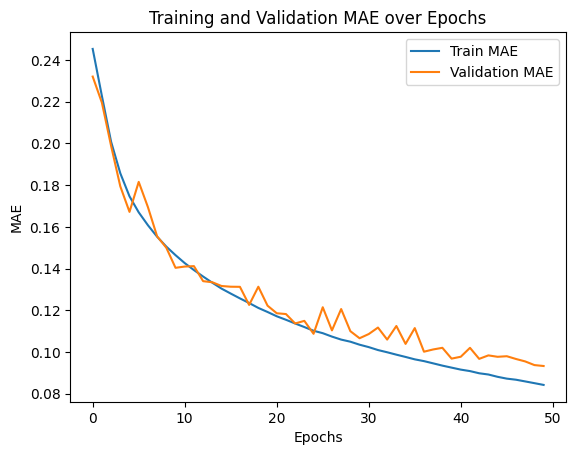

In [20]:
if path_to_current_model == "none":
    train_mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    plt.figure()
    plt.plot(train_mae, label='Train MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE over Epochs')
    plt.legend()

In [21]:
if path_to_current_model == "none":
    import json
    with open('models/cubic_history_5.json', 'w') as f:
        json.dump(history.history, f)